# Imports

In [114]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import bqplot as bqp
    from bqplot import pyplot as plt # bqplot is a plotting for jupyter
    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


# File selection

In [115]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Experiment-A5')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                    
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        df_end_flux_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        for i in range(len(df_end_flux_data)):
            for j in range(10):
                df_end_flux_data[i][j] = df_end_flux_data[i][j]* master_arr[i][-1][3]
                #[df_end_flux_data[i] * master_arr[i][-1][3]  for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_flux_data[i].append(df_end_flux_data[i][0]+df_end_flux_data[i][3]-df_end_flux_data[i][7]) 
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2','Trans_membrane_net']
        df_end_flux = pd.DataFrame(data = df_end_flux_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]

        
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [(master_arr[i][-1][7] - master_arr[i][-2][7])* master_arr[i][-1][3]  for i in range(len(comp_names_arr))]

        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Experiment-A5', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

TypeError: exceptions must derive from BaseException

File found and content loaded into memory


# Starting values

In [116]:
df_start

,Radius,Length,Volume,Na_i,K_i,Cl_i,X_i,z_i
Comp0_Soma,0.000010,0.0002,6.283185e-14,0.014002,0.12289,0.005165,0.154973,-0.85
Comp1,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp2,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp3,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp4,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp5,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp6,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp7,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp8,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85
Comp9,0.000005,0.0001,7.853982e-15,0.014002,0.12289,0.005165,0.154973,-0.85


# A) Compartment parameters

In [118]:
######### 
# GUI
drp_comp = widgets.Dropdown(description='Compartment:')


options_drp_comp = []
options_drp_comp.append('ALL COMPARTMENTS')

for i in range(len(comp_names_arr)):
    options_drp_comp.append(comp_names_arr[i])

drp_comp.options = options_drp_comp    


drp_param = widgets.Dropdown(description='Parameter:')
options_drp_param = ['Membrane Potential (Vm)','Cl- Reversal Potential (E-Cl)', 'K+ Reversal Potential (E-K)','Cl- Driving Force'
                        ,'Volume (pL)','',
                         'All ion concentrations','Na+ Conc.','K+ Conc.','Cl- Conc.','Impermeant anion Conc.']


drp_param.options = options_drp_param


sldr_start = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=5)


hbox_graph = widgets.HBox()
vbox_graph1 = widgets.VBox()
vbox_graph2 = widgets.VBox()
vbox_graph1.children =[drp_comp,drp_param]
vbox_graph2.children =[sldr_start]
hbox_graph.children = [vbox_graph1,vbox_graph2]

btn_main_graph = widgets.Button(description='Graph it!',button_style='success')
output10 = widgets.Output()
display(hbox_graph,btn_main_graph,output10)

number_of_colors = len(comp_names_arr)

color_arr = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


def plot_main_graph(param='',comp_num=0,all_comps =False,jump=1):
    
    
    start_t = sldr_start.value
      
        
    x_sc = bqp.LinearScale()
    y_sc = bqp.LinearScale()
    col_sc = bqp.ColorScale(scheme="RdYlGn")
    ax_x = bqp.Axis(scale = x_sc, label="Time(s)", min= start_t, max=t_arr[-1])
    ax_y = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='left')
    ax_y2 = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='right')
        
        
        
    if all_comps == True:
                      
        m_arr = []
        output10.clear_output()
                   
         
        
        for i in range(len(comp_names_arr)):
            col = color_arr[i]
            y_arr = []   
                #f1_title = "All Compartments"+" : " + "Time (s) vs " + drp_param.value 
                
            if param == 'Membrane Potential (Vm)':
                
                y_arr = [master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = [col], 
                    display_legend=True,labels= ['Vm - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Reversal Potential (E-Cl)':
                
                
                y_arr = [master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-Cl - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Reversal Potential (E-K)':
                
                y_arr = [master_arr[i][j][-2]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1], y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-K - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Driving Force':
                
                y_arr = [master_arr[i][j][-3]*1e3 - master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))] 
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
                
                
            elif param == 'Volume (pL)':
                
                y_arr = [master_arr[i][j][3]*1e12 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Vol. - '+comp_names_arr[i] ], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Na+ Conc.':
                
                y_arr = [master_arr[i][j][4]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Na+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Conc.':
                
                y_arr = [master_arr[i][j][5]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['K+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Conc.':
                
                y_arr = [master_arr[i][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['Cl- - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Impermeant anion Conc.':
                
                y_arr = [master_arr[i][j][7]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col], 
                       display_legend=True,labels= ['X -'+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))        
            
                
                
                       
                
        f1 = bqp.Figure(title ="", marks=m_arr, axes=[ax_x, ax_y],legend_location='top-right',scales={'x': x_sc, 'color': col_sc, 'y': y_sc})
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)
        
        
    if all_comps == False:            
            
            
        y_arr = []
            
        if param == 'Membrane Potential (Vm)':
                
            y_arr = [master_arr[comp_num][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Vm'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Reversal Potential (E-Cl)':
            
            y_arr = [master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bm1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-Cl'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Reversal Potential (E-K)':
                
            y_arr = [master_arr[comp_num][j][-2]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-K'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Driving Force':
             
            y_arr = [master_arr[comp_num][j][-3]*1e3 - master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]    
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[comp_num]], scales = {'x': x_sc, "y": y_sc})
                 
        elif param == 'Volume (pL)':
                
            y_arr = [master_arr[comp_num][j][3]*1e12 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'],
                       display_legend=True,labels= ['Vol.'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Na+ Conc.':
                
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Conc.':
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc}) 
             
        elif param == 'Cl- Conc.':
                
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc}) 
                
        elif param == 'Impermeant anion Conc.':
            
                   
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X Conc.'], scales = {'x': x_sc, "y": y_sc}) 
            
           
                
        elif param == 'All ion concentrations':
                
            m1 = []
            
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            a1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            a2 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                
            a3 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
                
            a4 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X'], scales = {'x': x_sc, "y": y_sc})
            
            
                
            m1 = [a1,a2,a3,a4]
                
                
                 
            f1 = bqp.Figure(title = comp_names_arr[comp_num] + ": all ion concentrations vs time", marks=m1, axes=[ax_x, ax_y],legend_location='top-right')
            f1.layout.height = '600px'
            f1.layout.width = '800px'
            output10.clear_output()
            with output10:    
                display(f1)
            return
            
    
    
        f1 = bqp.Figure(title = "", marks=[m1], axes=[ax_x, ax_y],legend_location='top-right')
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)

            
            
        
                
                
            

        #####


def btn_main_graph_clicked(b):
    
    
    start_t = int(sldr_start.value * 1000)

    

    
    
    
    
    if drp_comp.value == 'ALL COMPARTMENTS':
    
            param = drp_param.value
            plot_main_graph(param,all_comps=True)

    
    elif drp_comp.value != 'ALL COMPARTMENTS':
        
        
        for i in range(len(comp_names_arr)):
            if (drp_comp.value == comp_names_arr[i]):
                comp_num = i
              

        param = drp_param.value
        plot_main_graph(param,comp_num,all_comps=False)
         
        
btn_main_graph.on_click(btn_main_graph_clicked)

Button(button_style='success', description='Graph it!', style=ButtonStyle())

Output()

# B) Impermeant anion changes

In [104]:
##################################################################
# WIDGET INITIALIZATION:

lbl_xchange = widgets.Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')
btn_xchange = widgets.Button(description='Plot impermeant changes', button_style='info')

output_xchange = widgets.Output()

display(lbl_xchange,btn_xchange,output_xchange)


##################################################################
# IMPLEMENTATION:

          



def plot_xchange_graph():
    
    fig_xchange,(ax_conc,ax_charge) = mplt.subplots(2,1)
    fig_xchange.suptitle('Changes to intracellular Impermeant anion concentration and charge during simulation')
    ax_conc.set_ylabel("Concentration (mM)")
    ax_charge.set_ylabel("Valence/Charge")
    ax_charge.set_xlabel("Time(ms)")
    
  

    for i in range(len(comp_names_arr)):
        y_arr = [master_arr[i][j][7]*1e3 for j in range(len(master_arr[0]))]
        ax_conc.plot(t_arr,y_arr, label = comp_names_arr[i])
        y_arr = [master_arr[i][j][8] for j in range(len(master_arr[0]))]
        ax_charge.plot(t_arr,y_arr, label = comp_names_arr[i])
    
    
def btn_xchange_clicked(b):
    output_xchange.clear_output()
    with output_xchange:
        plot_xchange_graph()
    

btn_xchange.on_click(btn_xchange_clicked)

#l = len(comp_arr[1].z_arr)


#print(comp_arr[1].z_diff)

#for j in range (1000):
    #print(comp_arr[0].z_arr[round(l/1000*j)])

#print(comp_arr[2].z_arr)

#print(xflux_rate)
#print(comp_arr[0].flux_rate)

Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')

Button(button_style='info', description='Plot impermeant changes', style=ButtonStyle())

Output()

# C) Boundary graphs

In [113]:

#############################################################################################################
# Widget interface
output_equilib = widgets.Output()
output_equilib.layout = Layout(border='solid')
output_equilib_save = widgets.Output(Layout=Layout(border='solid'))
output_legend = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')

sldr_equilib = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=intervals)

btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")

hbox_equilib = widgets.HBox(children=[drp_equilib,sldr_equilib])
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(hbox_equilib, btn_equilib, output_equilib, output_equilib_save)

#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    
    int_equilib = sldr_equilib.value-1
  
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
    display(btn_equilib_save)
    
    with output_equilib:
        
        output_equilib.clear_output()
        
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')
        main_atpase = mpatches.Ellipse([mainx+3,mainy+16],width=2, height=4,fc = '#964b00')
        main_kcc2 = mpatches.Ellipse([mainx+8,mainy+16],width=4, height=2,fc = '#8f4f66')
        shapes_arr.append(main_rect)
        shapes_arr.append(main_atpase)
        shapes_arr.append(main_kcc2)
        
        m_net_in = 0
        m_net_out = 0

        ######## Main ATPASE:
        
        m_na_atpase = master_arr[temp_num][int_equilib][11]*1e23 * master_arr[temp_num][int_equilib][3]
        
        if m_na_atpase >0: #Sodium coming into the compartment           
            arrow_size = m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        else:
            arrow_size = -m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        shapes_arr.append(m_na_atpase_arrow)
        
        m_k_atpase = master_arr[temp_num][int_equilib][14]*1e23   * master_arr[temp_num][int_equilib][3]
        
        if m_k_atpase >0: #Potassium coming into the compartment
            arrow_size = m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
        else:
            arrow_size = -m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

        shapes_arr.append(m_k_atpase_arrow)
        
        ######## Main KCC2:
        
        m_k_kcc2 = master_arr[temp_num][int_equilib][15]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_k_kcc2 >0: #Potassium entering via KCC2
            arrow_size = m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
        
        else:
            arrow_size = -m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
            
        shapes_arr.append(m_k_kcc2_arrow)
        
        m_cl_kcc2 = master_arr[temp_num][int_equilib][18]*1e23  *master_arr[temp_num][int_equilib][3]
        if m_cl_kcc2 >0: #cl coming into the compartment
            arrow_size = m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
            
        else:
            arrow_size = -m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
        shapes_arr.append(m_cl_kcc2_arrow)
        
            
        ########## Main Na Leak:
        
        m_na_leak = mpatches.Rectangle([mainx+12, mainy+15.5], 2,1,fc='#000000') 
        shapes_arr.append(m_na_leak)
        
        m_d_na = master_arr[temp_num][int_equilib][10]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_na >0: #sodium coming into the compartment
            arrow_size = m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
           
        else:
            arrow_size = -m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
            
         
        shapes_arr.append(m_na_arrow)

        ########## Main K Leak:
        
        m_k_leak = mpatches.Rectangle([mainx+15, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_k_leak)
        
        m_d_k = master_arr[temp_num][int_equilib][13]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_d_k >0: #potassium coming into the compartment
            arrow_size = m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
          
        else:
            arrow_size = -m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
           
        shapes_arr.append(m_k_arrow)

        ########## Main Cl Leak:
        
        m_cl_leak = mpatches.Rectangle([mainx+18, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_cl_leak)
        
        m_d_cl = master_arr[temp_num][int_equilib][17]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_cl >0: #chloride coming into selected (main) compartment
            arrow_size = m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        else:
            arrow_size = -m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        shapes_arr.append(m_cl_arrow)




        ######## Right Compartment

        rightx = mainx+21
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            right_atpase = mpatches.Ellipse([rightx+3,righty+16],width=2, height=4,fc = '#964b00')
            right_kcc2 = mpatches.Ellipse([rightx+8,righty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(right_rect)
            shapes_arr.append(right_atpase)
            shapes_arr.append(right_kcc2)
            
            
            #### Right ATPase
            r_na_atpase = master_arr[temp_num+1][int_equilib][11]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_na_atpase >0: #Sodium coming into the compartment
                arrow_size = r_na_atpase*2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        
            else:
                arrow_size = -r_na_atpase *2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
                
            shapes_arr.append(r_na_atpase_arrow)

            r_k_atpase = master_arr[temp_num+1][int_equilib][14]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_atpase >0: #Sodium coming into the compartment
                arrow_size = r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
              
            else:
                arrow_size = -r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
               
            shapes_arr.append(r_k_atpase_arrow)
            
            ######## Right KCC2:
        
            r_k_kcc2 = master_arr[temp_num+1][int_equilib][15]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = r_k_kcc2*2
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
               
            else:
                arrow_size = -r_k_kcc2 *2 
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(r_k_kcc2_arrow)

            r_cl_kcc2 =  master_arr[temp_num+1][int_equilib][18]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_cl_kcc2 >0: #Cl coming into the compartment via KCC2
                arrow_size = +r_cl_kcc2*2  
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
               
            else:
                arrow_size = -r_cl_kcc2 *2    
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(r_cl_kcc2_arrow)
        
            
            #d_Na
            
            r_na_leak = mpatches.Rectangle([rightx+12, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_na_leak)
            
            r_d_na = master_arr[temp_num+1][int_equilib][10]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_na >0: #sodium coming into the compartment
                arrow_size = r_d_na *2
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
               
            else:
                arrow_size = -r_d_na*2 
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
             
            shapes_arr.append(r_na_arrow)

            #d_K
            
            r_k_leak = mpatches.Rectangle([rightx+15, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_k_leak)
            
            r_d_k = master_arr[temp_num+1][int_equilib][13]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_d_k >0: #potassium coming into the compartment
                arrow_size = r_d_k*2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
     
            else:
                arrow_size = -r_d_k *2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            shapes_arr.append(r_k_arrow)


            #d_Cl
            
            r_cl_leak = mpatches.Rectangle([rightx+18, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_cl_leak)
            
            r_d_cl = master_arr[temp_num+1][int_equilib][17]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_cl >0: #chloride coming into the compartment
                arrow_size = r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            else:
                arrow_size = -r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            shapes_arr.append(r_cl_arrow)

            #Right Electrodiffusion
            """
            r_ed_arr = ED_master_arr[temp_num][-1]
            
            r_ed_na = r_ed_arr[0]*1e15
            arrow_size = r_ed_na
            if r_ed_na >0: 
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls='dotted')

            else:
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, -arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
              
            shapes_arr.append(r_ed_na_arrow)
               

            r_ed_k = r_ed_arr[1]*1e15
            arrow_size= r_ed_k
            if r_ed_k >0:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
    
            else:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, -arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(r_ed_k_arrow)
                

            r_ed_cl = r_ed_arr[2]*1e15
            arrow_size = r_ed_cl
            if r_ed_cl >0: 
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, +arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                    
                
            else:
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, -arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            shapes_arr.append(r_ed_cl_arrow)
               
            """  

        ######## Left Compartment

        leftx = mainx-21
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            left_atpase = mpatches.Ellipse([leftx+3,lefty+16],width=2, height=4,fc = '#964b00')
            left_kcc2 = mpatches.Ellipse([leftx+8,lefty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(left_atpase)
            shapes_arr.append(left_kcc2)
            
            #### Left ATPase
            l_na_atpase = master_arr[temp_num-1][int_equilib][11]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_na_atpase >0: #Sodium coming into the compartment
                arrow_size = l_na_atpase*2 
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')

            else:
                arrow_size = -l_na_atpase *2
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
              
            shapes_arr.append(l_na_atpase_arrow)

            l_k_atpase = master_arr[temp_num-1][int_equilib][14]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_atpase >0: #Sodium coming into the compartment
                arrow_size = l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

            else:
                arrow_size = -l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(l_k_atpase_arrow)
            
            ######## Left KCC2:
        
            l_k_kcc2 = master_arr[temp_num-1][int_equilib][15]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
           
            else:
                arrow_size = -l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                 
            shapes_arr.append(l_k_kcc2_arrow)

            l_cl_kcc2 = master_arr[temp_num-1][int_equilib][18]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_cl_kcc2 >0: #Sodium coming into the compartment
                arrow_size = l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
             
            else:
                arrow_size = -l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(l_cl_kcc2_arrow)
            
            #d_Na
            
            l_na_leak = mpatches.Rectangle([leftx+12, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_na_leak)
            
            l_d_na = master_arr[temp_num-1][int_equilib][10]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_na >0: #sodium coming into the left compartment
                arrow_size = l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, -arrow_size, width=0.2, ec='#e7298a',fc='#e7298a')
                
             
            else:
                arrow_size = -l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
                
            shapes_arr.append(l_na_arrow)

            #d_K
            
            l_k_leak = mpatches.Rectangle([leftx+15, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_k_leak)
            
            l_d_k = master_arr[temp_num-1][int_equilib][13]*1e23 * master_arr[temp_num-1][int_equilib][3]
            if l_d_k >0: #potassium coming into the compartment
                arrow_size = l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            else:
                arrow_size = -l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(l_k_arrow)


            #d_Cl
            
            l_cl_leak = mpatches.Rectangle([leftx+18, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_cl_leak)
            
            l_d_cl = master_arr[temp_num-1][int_equilib][17]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_cl >0: #chloride coming into the compartment
                arrow_size = l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            else:
                arrow_size = -l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
            shapes_arr.append(l_cl_arrow)


            #Left compartment boundary (electrodiffusion):
            """"
            l_ed_arr = ED_master_arr[temp_num-1][-1]

            l_ed_na = l_ed_arr[0]*1e10
            if l_ed_na >0: #sodium leaving the L compartment, entering main compartment via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx-4, mainy+8, +5, 0, width=0.2,ec='#e7298a',fc='#e7298a',hatch ='+')
               
                shapes_arr.append(l_ed_na_arrow)
              
                
            else: # sodium entering via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx+2, mainy+8, -5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls =':')
                
                shapes_arr.append(l_ed_na_arrow)
               

            l_ed_k = l_ed_arr[1]*1e10
            if l_ed_k >0: #K leaving the compartment via ED
                l_ed_k_arrow = mpatches.FancyArrow(mainx-4, mainy+6, +5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               
            else:
                l_ed_k_arrow = mpatches.FancyArrow(mainx+2, mainy+6, -5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               

            l_ed_cl = l_ed_arr[2]*1e10
            if l_ed_cl >0: #sodium coming into the compartment
                l_ed_cl_arrow = mpatches.FancyArrow(mainx-4, mainy+4, +5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
                shapes_arr.append(l_ed_cl_arrow)
              
            else:
                l_ed_cl_arrow = mpatches.FancyArrow(mainx+2, mainy+4, -5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
                shapes_arr.append(l_ed_cl_arrow)
                
            """


        ######### legend
        leg_rect = mpatches.Rectangle([65,32],8,12, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)
        
        leg_atpase = mpatches.Ellipse([71,37],width=1, height=2,fc = '#964b00')
        shapes_arr.append(leg_atpase)
        ax.text(65.5,37,"ATPase", fontsize=12)
        
        leg_kcc2 = mpatches.Ellipse([71,35],width=2, height=1,fc = '#8f4f66')
        shapes_arr.append(leg_kcc2)
        ax.text(65.5,35,"KCC2", fontsize=12)
        
        leg_leak = mpatches.Rectangle([70, 33], 2,1,fc='#000000')
        shapes_arr.append(leg_leak)
        ax.text(65.5,33,"Leak", fontsize=12)




        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)

        
        
    
        
###########################################################################################################        
        

        
        

#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()

In [87]:

#############################################################################################################
# Widget interface
output_equilib = widgets.Output()
output_equilib.layout = Layout(border='solid')
output_equilib_save = widgets.Output(Layout=Layout(border='solid'))
output_legend = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')

sldr_equilib = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=intervals)

btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")

hbox_equilib = widgets.HBox(children=[drp_equilib,sldr_equilib])
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(hbox_equilib, btn_equilib, output_equilib, output_equilib_save)
display(btn_equilib_save)
#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    
    int_equilib = sldr_equilib.value-1
  
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
 
    
    with output_equilib:
        
        output_equilib.clear_output()
        
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')

        shapes_arr.append(main_rect)       
        
        ######## Main Transmembrane
        
       
        m_na_memb = df_end_flux.iloc[temp_num][0]*1e27
        m_na_memb_arrow = mpatches.FancyArrow(mainx+8, mainy+16,0,-m_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
        shapes_arr.append(m_na_memb_arrow)
        m_k_memb = df_end_flux.iloc[temp_num][3]*1e27   
        m_k_memb_arrow = mpatches.FancyArrow(mainx+11, mainy+16,0,-m_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
        shapes_arr.append(m_k_memb_arrow)
        m_cl_memb = df_end_flux.iloc[temp_num][7]*1e27   
        m_cl_memb_arrow = mpatches.FancyArrow(mainx+14, mainy+16,0,-m_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
        shapes_arr.append(m_cl_memb_arrow)
        
        

        ######## Right Compartment

        rightx = mainx+20
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            shapes_arr.append(right_rect)
        
            r_na_memb = df_end_flux.iloc[temp_num+1][0]*1e27
            r_na_memb_arrow = mpatches.FancyArrow(rightx+8, righty+16,0,-r_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
            shapes_arr.append(r_na_memb_arrow)
            r_k_memb = df_end_flux.iloc[temp_num+1][3]*1e27   
            r_k_memb_arrow = mpatches.FancyArrow(rightx+11, righty+16,0,-r_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
            shapes_arr.append(r_k_memb_arrow)
            r_cl_memb = df_end_flux.iloc[temp_num+1][7]*1e27   
            r_cl_memb_arrow = mpatches.FancyArrow(rightx+14, righty+16,0,-r_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
            shapes_arr.append(r_cl_memb_arrow)

            #Right Electrodiffusion
           
            
            r_ed_na = df_end_ed.iloc[temp_num][0]*1e45
            r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, r_ed_na, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
            shapes_arr.append(r_ed_na_arrow)
            r_ed_k = df_end_ed.iloc[temp_num][1]*1e45
            r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, r_ed_k, 0, width=0.2,ec='#7570b3',fc='#7570b3')
            shapes_arr.append(r_ed_k_arrow)
            r_ed_cl = df_end_ed.iloc[temp_num][2]*1e45
            r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4,r_ed_cl, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
            shapes_arr.append(r_ed_cl_arrow)
               
            

        ######## Left Compartment

        leftx = mainx-20
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            
            
            l_na_memb = df_end_flux.iloc[temp_num-1][0]*1e27
            l_na_memb_arrow = mpatches.FancyArrow(leftx+8, lefty+16,0,-l_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
            shapes_arr.append(l_na_memb_arrow)
            l_k_memb = df_end_flux.iloc[temp_num-1][3]*1e27   
            l_k_memb_arrow = mpatches.FancyArrow(leftx+11, lefty+16,0,-l_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
            shapes_arr.append(l_k_memb_arrow)
            l_cl_memb = df_end_flux.iloc[temp_num-1][7]*1e27   
            l_cl_memb_arrow = mpatches.FancyArrow(leftx+14, lefty+16,0,-l_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
            shapes_arr.append(l_cl_memb_arrow)

            #Left compartment boundary (electrodiffusion):
            l_ed_na = df_end_ed.iloc[temp_num-1][0]*1e45
            l_ed_na_arrow = mpatches.FancyArrow(mainx, lefty+8, l_ed_na, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
            shapes_arr.append(l_ed_na_arrow)
            l_ed_k = df_end_ed.iloc[temp_num-1][1]*1e45
            l_ed_k_arrow = mpatches.FancyArrow(mainx, lefty+6, l_ed_k, 0, width=0.2,ec='#7570b3',fc='#7570b3')
            shapes_arr.append(l_ed_k_arrow)
            l_ed_cl = df_end_ed.iloc[temp_num-1][2]*1e45
            l_ed_cl_arrow = mpatches.FancyArrow(mainx, lefty+4,l_ed_cl, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
            shapes_arr.append(l_ed_cl_arrow)


        ######### legend
        leg_rect = mpatches.Rectangle([65,38],8,6, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)



        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)


#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()

Button(button_style='info', description='Save Graph as png', style=ButtonStyle())

RadioButtons(options=('Absolute concentrations', 'Fluxes'), value='Absolute concentrations')

Button(button_style='success', description='Plot', style=ButtonStyle())

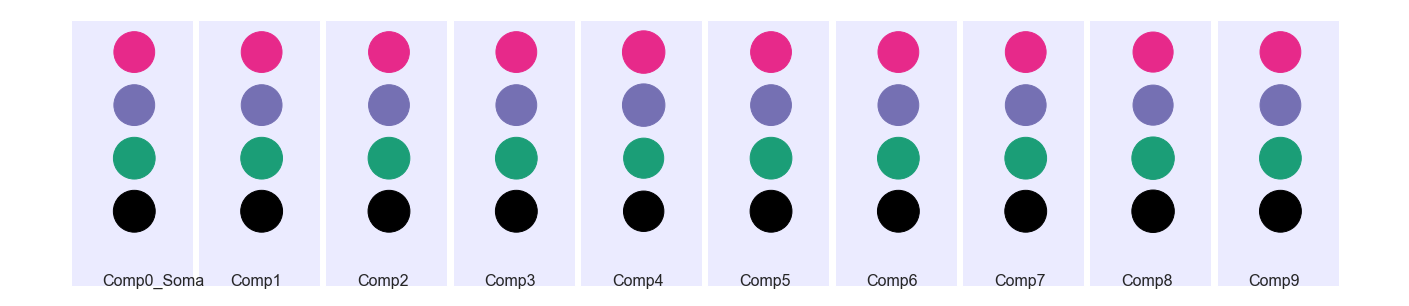

3.190754631953712e-27


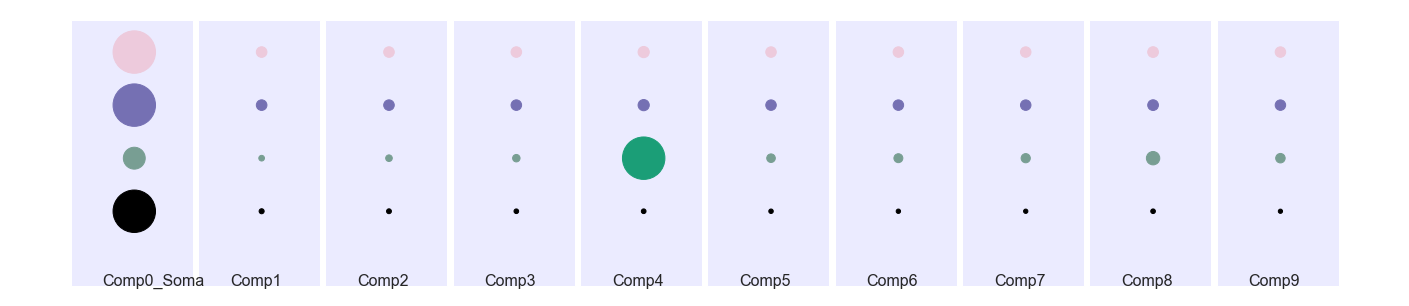

In [106]:
###################################################
btn_overview = widgets.Button(description ="Plot", button_style='success')
rdb_overview_select = widgets.RadioButtons(options=["Absolute concentrations","Fluxes"])

display(rdb_overview_select, btn_overview)

def btn_overview_clicked(b):
    
    f_overview = mplt.figure(figsize=(25,10))
    ax_overview = mplt.gca()
    shapes_arr=[]
    x_val = 0
    y_val = 0
    
    if rdb_overview_select.value =="Absolute concentrations":  
        na_unit = df_end["Na_i"].max()
        k_unit = df_end["K_i"].max()
        cl_unit = df_end["Cl_i"].max()
        x_unit = df_end["X_i"].max()
        
        
    elif rdb_overview_select.value =="Fluxes":
        
        df_temp = abs(df_end_net_flux)
        na_unit = abs(df_temp["Na-Net"].max())
        print(na_unit)
        k_unit = abs(df_temp["K-Net"].max())
        cl_unit = abs(df_temp["Cl-Net"].max())
        x_unit = abs(df_temp["X-Net"].max())
        
    
    for i in range(len(df_end)):
        
        comp_rect = mpatches.Rectangle([x_val,y_val],11.5,25, fc='#ebebff')
        shapes_arr.append(comp_rect)
        ax_overview.text(x_val+3,y_val,df_end.index[i], fontsize=16)
        
        if rdb_overview_select.value =="Absolute concentrations": 

            na_rad = df_end.iloc[i,3] / na_unit * 2
            na_circle = mpatches.Circle([x_val+6,y_val+22],na_rad, fc='#e7298a',ec='#e7298a')
            shapes_arr.append(na_circle)

            k_rad = df_end.iloc[i,4] / k_unit * 2
            k_circle = mpatches.Circle([x_val+6,y_val+17],na_rad, ec='#7570b3',fc='#7570b3')
            shapes_arr.append(k_circle)

            cl_rad = df_end.iloc[i,5] / cl_unit * 2
            cl_circle = mpatches.Circle([x_val+6,y_val+12],cl_rad, ec='#1b9e77',fc='#1b9e77')
            shapes_arr.append(cl_circle)
            
            x_rad = df_end.iloc[i,6] / x_unit * 2
            x_circle = mpatches.Circle([x_val+6,y_val+7],x_rad, ec='black',fc='black')
            shapes_arr.append(x_circle)
        
        if rdb_overview_select.value =="Fluxes": 

            
            na_rad = df_end_net_flux.iloc[i,0] / na_unit * 2
            if na_rad > 0:
                na_circle = mpatches.Circle([x_val+6,y_val+22],na_rad, fc='#e7298a',ec='#e7298a')
            else: 
                na_circle = mpatches.Circle([x_val+6,y_val+22],na_rad, fc='#edcadc',ec='#edcadc')
            shapes_arr.append(na_circle)
            
            k_rad = df_end_net_flux.iloc[i,1] / k_unit * 2
            if k_rad > 0:
                k_circle = mpatches.Circle([x_val+6,y_val+17],na_rad, ec='#7570b3',fc='#7570b3')
            else: 
                k_circle = mpatches.Circle([x_val+6,y_val+17],na_rad, ec='#8986a6',fc='#8986a6')
            shapes_arr.append(k_circle)

            cl_rad = df_end_net_flux.iloc[i,2] / cl_unit * 2
            if cl_rad > 0:
                cl_circle = mpatches.Circle([x_val+6,y_val+12],cl_rad, ec='#1b9e77',fc='#1b9e77')
            else: 
                cl_circle = mpatches.Circle([x_val+6,y_val+12],cl_rad, ec='#789e93',fc='#789e93')
            shapes_arr.append(cl_circle)
            
            x_rad = df_end_net_flux.iloc[i,3] / x_unit * 2
            x_circle = mpatches.Circle([x_val+6,y_val+7],x_rad, ec='black',fc='black')
            shapes_arr.append(x_circle)
            
            
        x_val = x_val + 12
        
            
            
            
        
        
        
        
    for j in range(len(shapes_arr)):
        ax_overview.add_patch(shapes_arr[j]) 
        
    ax_overview.axis("off")
    mplt.axis("Scaled")
       


btn_overview.on_click(btn_overview_clicked)


### Simulation end values 

In [109]:
df_end

,Radius,Length,Volume,Na_i,K_i,Cl_i,X_i,z_i,Vm (mV),Ek (mV),ECl (mV),Cl-Driving force (mV)
Comp0_Soma,0.000010,0.0002,6.283186e-14,0.014009,0.122853,0.005165,0.154973,-0.850000,-72.591684,-95.099445,-83.845556,11.253873
Comp1,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588517,-95.096279,-83.842389,11.253873
Comp2,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588518,-95.096283,-83.842390,11.253873
Comp3,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588519,-95.096286,-83.842391,11.253873
Comp4,0.000005,0.0001,8.689767e-15,0.014583,0.127883,0.004962,0.149572,-0.919702,-73.664052,-96.171966,-84.918070,11.254018
Comp5,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588520,-95.096291,-83.842393,11.253873
Comp6,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588521,-95.096293,-83.842394,11.253873
Comp7,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588521,-95.096295,-83.842394,11.253873
Comp8,0.000005,0.0001,8.254094e-15,0.013771,0.120765,0.005255,0.157209,-0.822725,-72.133615,-94.641378,-83.387477,11.253862
Comp9,0.000005,0.0001,7.853191e-15,0.014007,0.122838,0.005166,0.154988,-0.850000,-72.588522,-95.096297,-83.842395,11.253873


### Transmembrane fluxes


In [111]:
df_end_flux

,Na_net,Na_leak,Na_Atpase,K_net,K_leak,K_Atpase,K_kcc2,Cl_net,Cl_leak,Cl_kcc2,Trans_membrane_net
Comp0_Soma,-3.190755e-27,3.517886e-23,-3.518206e-23,3.187730e-27,-2.052007e-23,2.345470e-23,-2.931441e-24,-4.262782e-30,2.931437e-24,-2.931441e-24,1.238235e-30
Comp1,-7.971440e-28,8.794274e-24,-8.795071e-24,7.967172e-28,-5.129761e-24,5.863381e-24,-7.328235e-25,-1.104184e-30,7.328224e-25,-7.328235e-25,6.773224e-31
Comp2,-7.947594e-28,8.794276e-24,-8.795071e-24,7.958880e-28,-5.129761e-24,5.863381e-24,-7.328237e-25,-1.288355e-30,7.328224e-25,-7.328237e-25,2.416959e-30
Comp3,-7.926796e-28,8.794278e-24,-8.795071e-24,7.951640e-28,-5.129762e-24,5.863381e-24,-7.328238e-25,-1.451932e-30,7.328224e-25,-7.328238e-25,3.936316e-30
Comp4,-8.419455e-28,9.250832e-24,-9.251674e-24,8.010014e-28,-5.396113e-24,6.167783e-24,-7.708691e-25,8.268752e-30,7.708774e-25,-7.708691e-25,-4.921292e-29
Comp5,-7.896019e-28,8.794281e-24,-8.795071e-24,7.940932e-28,-5.129763e-24,5.863381e-24,-7.328241e-25,-1.671240e-30,7.328224e-25,-7.328241e-25,6.162459e-30
Comp6,-7.883953e-28,8.794283e-24,-8.795071e-24,7.936738e-28,-5.129763e-24,5.863381e-24,-7.328241e-25,-1.741853e-30,7.328224e-25,-7.328241e-25,7.020393e-30
Comp7,-7.874904e-28,8.794284e-24,-8.795071e-24,7.933592e-28,-5.129763e-24,5.863381e-24,-7.328242e-25,-1.793855e-30,7.328224e-25,-7.328242e-25,7.662673e-30
Comp8,-8.059835e-28,9.015963e-24,-9.016769e-24,8.157066e-28,-5.259067e-24,6.011180e-24,-7.512966e-25,-2.607317e-30,7.512940e-25,-7.512966e-25,1.233042e-29
Comp9,-7.865929e-28,8.794284e-24,-8.795071e-24,7.930469e-28,-5.129763e-24,5.863381e-24,-7.328243e-25,-1.845523e-30,7.328224e-25,-7.328243e-25,8.299480e-30


### Electrodiffusion fluxes

In [15]:

print("Positive Values --> ion leaving compA to enter compB")
print("Negative Values --> ion leaving compB to enter compA")
df_end_ed

Positive Values --> ion leaving compA to enter compB
Negative Values --> ion leaving compB to enter compA


,Na_ED_flux,K_ED_flux,Cl_ED_flux
Comp0_Soma <- Comp1,-1.426130e-44,1.425192e-44,-3.840639e-48
Comp1 <- Comp2,-1.579704e-45,1.578333e-45,-5.052784e-50
Comp2 <- Comp3,-1.377697e-45,1.375066e-45,5.348097e-49
Comp3 <- Comp4,-1.176372e-45,1.171448e-45,1.262034e-48
Comp4 <- Comp5,-1.106156e-45,1.135838e-45,-6.260367e-48
Comp5 <- Comp6,-7.993464e-46,8.223349e-46,-4.739523e-48
Comp6 <- Comp7,-5.994283e-46,6.178652e-46,-3.756251e-48
Comp7 <- Comp8,-3.997975e-46,4.133211e-46,-2.727076e-48
Comp8 <- Comp9,-2.095097e-46,2.152219e-46,-1.132156e-48


### Net flux


In [107]:
df_end_net_flux

,Na-Net,K-Net,Cl-Net,X-Net,Total
Comp0_Soma,-3.190755e-27,3.187730e-27,-4.262782e-30,1.639201e-24,-1.639199e-24
Comp1,-7.971440e-28,7.967172e-28,-1.104184e-30,1.947504e-25,-1.947497e-25
Comp2,-7.947594e-28,7.958880e-28,-1.288355e-30,1.877544e-25,-1.877520e-25
Comp3,-7.926796e-28,7.951640e-28,-1.451932e-30,1.789548e-25,-1.789508e-25
Comp4,-8.419455e-28,8.010014e-28,8.268752e-30,1.811386e-25,-1.811878e-25
Comp5,-7.896019e-28,7.940932e-28,-1.671240e-30,1.723025e-25,-1.722964e-25
Comp6,-7.883953e-28,7.936738e-28,-1.741853e-30,1.686803e-25,-1.686733e-25
Comp7,-7.874904e-28,7.933592e-28,-1.793855e-30,1.659012e-25,-1.658935e-25
Comp8,-8.059835e-28,8.157066e-28,-2.607317e-30,1.787120e-25,-1.786997e-25
Comp9,-7.865929e-28,7.930469e-28,-1.845523e-30,1.632169e-25,-1.632086e-25


# D) Heatmaps

In [119]:

# Make the same graph as above but with absolute changes

############################################
# GUI SETUP

btn_potentials = widgets.Button(description='Compare voltages', button_style='info')
sldr_potentials = widgets.IntSlider(description='Interval', min = 2, max=len(interval_arr), value=len(interval_arr))
output_potentials = widgets.Output()
hbox_potentials = widgets.HBox(children=[btn_potentials,sldr_potentials])

display(hbox_potentials, output_potentials)

############################################

def btn_potentials_clicked(b):
    
    heatmap_arr =[]
    interval = sldr_potentials.value-1
    
    #Heatmap data
    for i in range(len(comp_names_arr)-1,-1,-1):
        temp_arr = [] #holds values for a particular compartment
        abs_vm =  master_arr[i][interval][-3]*1e3 - master_arr[i][2][-3]*1e3
        temp_arr.append(abs_vm) #Vm
        abs_ecl =   master_arr[i][interval][-1]*1e3 - master_arr[i][2][-1]*1e3
        temp_arr.append(abs_ecl) #ECl
        abs_drf_cl =  (master_arr[i][interval][-3]-master_arr[i][interval][-1])*1e3 - (master_arr[i][2][-3]-master_arr[i][2][-1])*1e3
        temp_arr.append(abs_drf_cl) #Cl Driving Force
        heatmap_arr.append(temp_arr)
    
    
    #Creating figure
    with output_potentials:
        
        output_potentials.clear_output()
        sns.set(font_scale=2)
        fig_heatmap, ax = mplt.subplots(figsize=(15,10))
        ax = sns.heatmap(heatmap_arr, center=0, cmap="icefire", linewidth=2,cbar_kws={'label':'mV'})
        ax.set_xticklabels(['Vm','ECl','Cl driving force'], fontsize=20)
        ax.set_yticklabels(comp_names_arr[::-1], fontsize=12)
        ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        fig_heatmap.suptitle("Absolute Voltage changes at specific interval", fontsize=20)
        
        mplt.show()
    
    
    
btn_potentials.on_click(btn_potentials_clicked)

Output()

IndexError: list index out of range

IndexError: list index out of range